In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
%matplotlib inline

In [102]:
p_j = os.path.join

## Helper functions

$PBIAS = 100 \frac{ \sum_{i=1}^N { \left( S_i - O_i \right) } } { \sum_{i=1}^N O_i} $

In [106]:
#--------------------------------------------------------------------------------------
# Loading data:

def get_header(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if "variables" in line.lower():
                return lines[1].replace('"', '').split('=')[1].split(',')

def get_hydrograph_data(fname):
    return pd.read_csv(fname, skiprows=[0, 1, 2], delim_whitespace=True,
                header=None, index_col=0, names=get_header(fname),
                usecols=[0, 1])

def get_wb_data(fname):
    wb = pd.read_csv(fname, skiprows=[0, 1, 2], delim_whitespace=True,
                header=None, index_col=0, names=get_header(fname))
    return wb[wb.columns[0:-1]]

def load_obj(filename):
    if filename.endswith('.pkl'):
        with open(filename, 'rb') as f:
            print("Loading: ", filename)
            p = pickle.load(f)
            return p
        # End with
    else:
        raise TypeError('File type not recognised as "pkl": {}'.format(filename))
    # End if                

def load_obj(filename):
    return pd.read_pickle(filename)

def load_csvs(targets):
    toe_locations = {}
    water_balances = {}
    for target in force_targets:
        suffix = target.split("_")[-1]
        toe_locations[target] =\
            pd.read_csv("multi_slope/multi_slope_slope_{}_toe_locations.csv".format(suffix), index_col='Time')
        water_balances[target] =\
            pd.read_csv("multi_slope/multi_slope_slope_{}_water_balances.csv".format(suffix), index_col='Time')
    return [toe_locations, water_balances, force_targets]

#--------------------------------------------------------------------------------------
# Plotting:

def plot_flux_changes(ax):
    for flux_change in flux_changes:
        ax.axvline(flux_change, linestyle='--', color='grey', alpha=0.4)

def discrete_cmap(N, base_cmap=None, limits=[0, 1]):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(limits[0], limits[1], N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

size_human_units = [115,85]
def mm_to_inches(num):
    if type(num) in [float, int]:
        return num * 0.0393701
    elif type(num) == list:
        return [x * 0.0393701 for x in num]        
        
#--------------------------------------------------------------------------------------
# Model metrics:

# 1. Root mean square error
def rmse(obs, sim):
    rmse = np.sum((obs - sim) ** 2 / float(len(obs)))
    return rmse

# 2. Percent bias
def pbias(obs, sim):
    return 100 * np.sum(sim - obs) / np.sum(obs)


def trendline(xd, yd, ax, alias='', order=1, c='r', alpha=1, Rval=True):
    """Make a line of best fit"""

    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)

    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0

    minxd = np.min(xd)
    maxxd = np.max(xd)

    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept

    #Plot trendline
    ax.plot(xl, yl, c, alpha=alpha, linestyle='--')

    #Calculate R Squared
    p = np.poly1d(coeffs)

    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot

    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(yd) + 0.2 * np.min(yd),
                 '$R^2 = %0.2f$' % Rsqr)
    else:
        #Return the R^2 value:
        return Rsqr

# Flume and experiment details

In [4]:
prefix = "flume_new" # Prefix for filenames to read 

In [5]:
flux_changes = [0, 1816, 3273, 4800, 7020, 9004, 10850, 12120, 13800, 15200] # Time of change of flux in flume experiments

In [6]:
# Flume dimensions
flume_length = 8 # Length of the flume
flume_width = 0.25 # Width of the flume
sand_height = 0.45 # Height of the sand medium
dh_dl = 0.455 / 0.45 # Slope of the flumes
# Experiment start time
start_experiment = 7776000.0 # Reference time for when experiment started relative to elapsed time on the loggers
# Model setup
horizontal_cells = 80 # Number of models cells used to simulate the flume in the horizontal direction

## Read in stream front data from flume experiments

In [7]:
stream_toe_observed = pd.read_csv('./obs_data/stream_length.dat')
stream_toe_observed.loc[:, 'Flow [m$^3$/s]'] = stream_toe_observed['Flow [L/min]'] / 60. / 1000. 
stream_toe_observed.loc[:, 'K [m/s]'] = stream_toe_observed.apply(
    lambda x: x['Flow [L/min]'] / 1000. / 60. / (flume_width * x[' Streamflow Length [m]']) / dh_dl, axis=1)

/var/folders/3r/w22zb81102dc4rcc4rb5rxmr0000gr/T/ipykernel_59993/3820047426.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  lambda x: x['Flow [L/min]'] / 1000. / 60. / (flume_width * x[' Streamflow Length [m]']) / dh_dl, axis=1)


## Read in the groundwater outflow data

In [27]:
gw_bin = pd.read_csv(r"./obs_data/2017_August_experiment/2017-08-22/groundwater_bin/groundwater_outflow.csv")
gw_bin.loc[:, "Q [L/min]"] = gw_bin.apply(lambda x: x['Q'] * 1000.0 * 60.0, axis=1)
# There was an error with the clock in the groundwater outflow vessel pressure transducer
# logger which required adjusting
gw_bin.loc[:, "time_elapsed_adjust"] = gw_bin.loc[:, "time_elapsed"] + 300

## Read in the simulation data

In [28]:
#for x in np.linspace(0.1, flume_length, horizontal_cells):
#    print(f"{x:.1f}")

In [120]:
stream_hydrographs = pd.DataFrame()
for index, x in enumerate(np.linspace(0.1, flume_length, horizontal_cells)):
    stream_hydrographs.loc[:, str(x)] = get_hydrograph_data(f'{prefix}o.hydrograph._x{x:.1f}_.dat')['Surface']            
    
toe_loc = []                           
for row in stream_hydrographs.iterrows():
    toe_loc_temp = 0.0
    for col in row[1].keys():
        if row[1][col] > 0:
            toe_loc_temp = col
    toe_loc += [float(toe_loc_temp)]

toe_location = pd.DataFrame( data={'toe_loc':toe_loc}, index=stream_hydrographs.index)
# Adjust for the start time to get start of experiment at time 0
toe_location.index = toe_location.index - start_experiment
toe_location = toe_location[toe_location.index >= 0]
    
wb = get_wb_data('{}o.water_balance.dat'.format(prefix))
wb.index = wb.index - start_experiment
wb = wb[wb.index >= 0]
wb.loc[:, 'Helev_3_neg'] = wb['Head_3'] * -1
wb.loc[:, 'Helev_3_neg [L/min]'] = wb.apply(lambda x: x['Helev_3_neg'] * 1000.0 * 60.0, axis=1) 

other_cols = ['Error rel', 'Error percent']
plot_cols = [u'Fnodal_1', u'crit_depth', u'Helev_3', u'NET1 Sources/Sinks', u'PM',
       u'Overland', u'NET2 Accumulation', u'ERROR (NET1-NET2)', u'Infilt', u'Exfilt']

outflow = pd.read_excel('obs_data/Outflow_levels_march.xlsx')
outflow = outflow[["Time (from internet, should match Calvin's computer)",
                   'Qout m3/s']]
outflow.columns = ['Time', 'Outflow [m$^3$/s]']                  
today = datetime.date.today()
combine = lambda x: datetime.datetime.combine(today, x)
outflow.loc[:, 'ElapsedTime'] = outflow['Time'].apply(lambda x: combine(x) - combine(outflow['Time'].iloc[0]))

In [121]:
stream_toe_observed.loc[:, 'sim'] = toe_location[toe_location.index.isin(stream_toe_observed[' Time [s]'])]['toe_loc'].tolist()
stream_toe_observed.loc[:, "residual"] = stream_toe_observed.loc[:, " Streamflow Length [m]"] - stream_toe_observed.loc[:, "sim"]

In [122]:
wb_copy = wb["Helev_3_neg"].copy() # [L/min]"].copy()
wb_copy = pd.concat([wb_copy, pd.DataFrame(index=gw_bin.time_elapsed_adjust.astype(float))])
wb_copy = wb_copy.sort_index()
wb_copy = wb_copy.interpolate(method='index')

In [123]:
gw_bin.loc[:, 'sim'] = wb_copy[wb_copy.index.isin(gw_bin.time_elapsed_adjust)][0].tolist()

In [124]:
print("Model matched the observed location with an average difference of {} m \u00B1 {} m.".format(
        stream_toe_observed.loc[:, "residual"].mean(), stream_toe_observed.loc[:, "residual"].std()))

print("Adjusted model matched the observed location with an average difference of {} m \u00B1 {} m.".format(
        stream_toe_observed.loc[1:, "residual"].mean(), stream_toe_observed.loc[1:, "residual"].std()))

Model matched the observed location with an average difference of -0.11624999999999991 m ± 0.26081945041404747 m.
Adjusted model matched the observed location with an average difference of -0.04714285714285703 m ± 0.18652205282613704 m.


In [125]:
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
#---- PLOTTING ----------------------------------------------------------------
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------

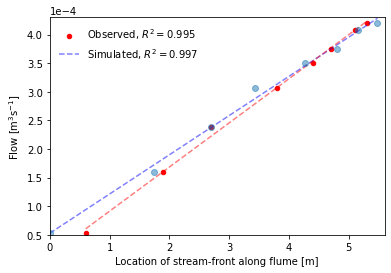

In [126]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.errorbar(stream_toe_observed[' Streamflow Length [m]'].tolist(), 
            stream_toe_observed['Flow [m$^3$/s]'].tolist(),
            #stream_toe_observed['Flow [L/min]'].tolist(),
            #xerr=0.2, 
            ecolor='blue', fmt='o', alpha=0.5)

stream_toe_observed.plot(kind='scatter', y='Flow [m$^3$/s]', x='sim', 
                         label='Simulated', ax=ax, color='red', edgecolor='red', legend=False)
ax.set_xlabel('Location of stream-front along flume [m]')
ax.set_xlim(0.0, 5.6)
ax.set_ylim(0.00005, 0.00043)

robs = trendline(stream_toe_observed[' Streamflow Length [m]'].tolist(), 
          stream_toe_observed['Flow [m$^3$/s]'].tolist(),
          ax, c='blue', alpha=0.5)

rsim = trendline(stream_toe_observed['sim'].tolist(), 
          stream_toe_observed['Flow [m$^3$/s]'].tolist(),
          ax, c='red', alpha=0.5)

ax.legend(['Observed, $R^2 = {0:0.3f}$'.format(robs),
           'Simulated, $R^2 = {0:0.3f}$'.format(rsim)], 
           loc='upper left', scatterpoints=1, 
           frameon=False, fontsize=10)
ax.set_ylabel("Flow [m$^3$s$^{-1}$]")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig("Q_vs_stream_front_location.png", dpi=300)

In [127]:
stream_toe_observed

,Flow [L/min],Streamflow Length [m],Time [s],Flow [m$^3$/s],K [m/s],sim,residual
0,3.2,0.00,1816,0.000053,inf,0.6,-0.60
1,9.6,1.74,3273,0.000160,0.000364,1.9,-0.16
2,14.3,2.70,4800,0.000238,0.000349,2.7,0.00
3,18.4,3.43,7020,0.000307,0.000354,3.8,-0.37
4,21.0,4.27,9004,0.000350,0.000324,4.4,-0.13
5,22.5,4.80,10850,0.000375,0.000309,4.7,0.10
6,24.5,5.15,12120,0.000408,0.000314,5.1,0.05
7,25.2,5.48,13800,0.000420,0.000303,5.3,0.18


[Text(0, 0.9400000000000001, ''),
 Text(0, 0.9600000000000001, ''),
 Text(0, 0.9800000000000001, ''),
 Text(0, 1.0, ''),
 Text(0, 1.02, ''),
 Text(0, 1.04, ''),
 Text(0, 1.06, '')]

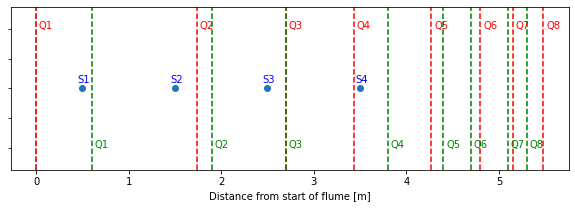

In [128]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.scatter([0.500, 1.500, 2.500, 3.500], [1, 1, 1, 1])
for ind, val in enumerate([0.500, 1.500, 2.500, 3.500]):
    ax.text(val - 0.05, 1.004, f"S{ind+1}", color='blue')
ax.axvline(0, linestyle="--", color='grey')
for ind, front in enumerate(stream_toe_observed[' Streamflow Length [m]']):
    ax.axvline(front, linestyle="--", color='red')
    ax.text(front + 0.03, 1.04, f"Q{ind+1}", color='red')
for ind, front in enumerate(stream_toe_observed['sim']):
    ax.axvline(front, linestyle="--", color='green')
    ax.text(front + 0.03, 0.96, f"Q{ind+1}", color='green')
    
ax.set_xlabel("Distance from start of flume [m]")
ax.set_yticklabels("")

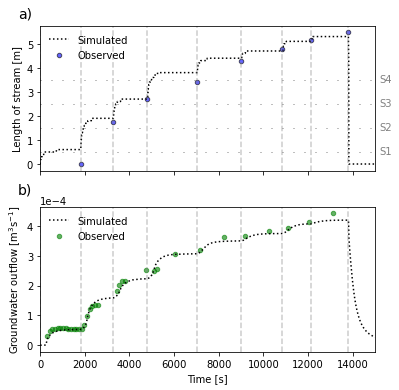

In [129]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(211)
toe_location.plot(ax=ax, legend=False, linestyle=':', color='black')
ax.scatter(x=stream_toe_observed[' Time [s]'], y=stream_toe_observed[' Streamflow Length [m]'], 
           edgecolor='black', alpha=0.6, facecolor='blue', s=20)
ax.legend(['Simulated', 'Observed'], loc='upper left', scatterpoints=1, 
          frameon=False, fontsize=10)
ax.set_ylabel('Length of stream [m]', fontsize=10)
ax.set_xlabel("")#'Time [s]', fontsize=10)
ax.set_xticklabels("")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlim(0, 15000)
ax.text(-1000, 6.1, "a)", fontsize=14)
plot_flux_changes(ax)

for ind, sensor in enumerate([0.500, 1.500, 2.500, 3.500]):
    ax.axhline(sensor, linestyle=(0, (1, 10)), color='grey', linewidth=1)
    ax.text(15200, sensor - 0.1, f"S{ind + 1}", color='grey')

ax2 = fig.add_subplot(2, 1, 2)

#gw_bin = pd.read_csv(r".\obs_data\2017 August experiment\2017-08-22\groundwater bin\groundwater_outflow.csv")
# Compare the observed and simulated groundwater outflow
ax2 = wb.loc[:, 'Helev_3_neg'].plot(label='simulated', linestyle=':', color='black')
ax2.scatter(x=gw_bin['time_elapsed_adjust'], y=gw_bin['Q'], facecolor='green', alpha=0.6, label='observed', s=20)
ax2.set_xlim(0, 15000)
#ax2.set_ylim(0, 25)#0.0005)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Groundwater outflow [m$^3$s$^{-1}$]')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.legend(['Simulated', 'Observed'], loc='upper left', scatterpoints=1, 
          frameon=False, fontsize=10)
ax2.text(-1000, 0.00051, "b)", fontsize=14)
plot_flux_changes(ax2)
plt.subplots_adjust(hspace=0.25)
#plt.savefig("Stream_length_and_groundwater_discharge_obs_v_sim.png", dpi=300)

Text(2e-05, 0.00038, 'RMSE = 1.45e-10 m$^3$s$^-$$^1$ \nPBIAS = -3.95%')

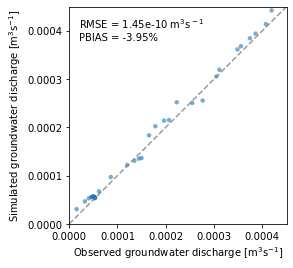

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
gw_bin.plot(kind='scatter', x='sim', y='Q', ax=ax, edgecolor='none', alpha=0.6)
max_val = 4.5E-4
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel("Observed groundwater discharge [m$^3$s$^{-1}$]")
ax.set_ylabel("Simulated groundwater discharge [m$^3$s$^{-1}$]")
ax.plot((0, max_val), (0, max_val), linestyle='--', color='grey', alpha=0.8)
ax.set_yticks([0, 0.0001, 0.0002, 0.0003, 0.0004])
gw_rmse = rmse(gw_bin['Q'], gw_bin['sim'])
gw_pbias = pbias(gw_bin['Q'], gw_bin['sim'])
ax.text(2E-5, 3.8E-4, f"RMSE = {gw_rmse:.2e} m$^3$s$^-$$^1$ \nPBIAS = {gw_pbias:.2f}%")

Text(0.15, 5, 'RMSE = 0.073 m\nPBIAS = 3.37%')

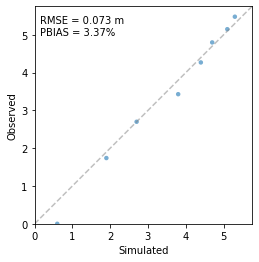

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
stream_toe_observed.plot(kind='scatter', x='sim', y=' Streamflow Length [m]', ax=ax, edgecolor='none', alpha=0.6)
ax.set_ylabel("Observed")
ax.set_xlabel("Simulated")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
#new_lim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
new_lim = [0, max(xlim[1], ylim[1])]
ax.set_xlim(new_lim)
ax.set_ylim(new_lim)
ax.plot(new_lim, new_lim, linestyle='--', color='grey', alpha=0.5)

str_wet_front_rmse = rmse(stream_toe_observed[' Streamflow Length [m]'], stream_toe_observed['sim'])
str_wet_front_pbias = pbias(stream_toe_observed[' Streamflow Length [m]'], stream_toe_observed['sim'])
ax.text(0.15, 5, f"RMSE = {str_wet_front_rmse:.3f} m\nPBIAS = {str_wet_front_pbias:.2f}%")

# Numerical experiments results

In [99]:
theoretical_experiments = {'multi_uniform_var':True,
                           'multi_heterogeneous_k':True,
                           'multi_bed_elevation':True,
                           'multi_heterogeneous_mannings_n':False, # Not easily implemented yet due to HGS limitations
                           'multi_slope':True}

master_analysis = {key:{} for key in theoretical_experiments if theoretical_experiments[key]}                           
                           
samples = 30
flows = np.linspace(0, 3E-4, 31)
period_between_flow_changes = 2500.0
locs = np.arange(2500.0, 2500.0 * 31, 2500.0)

def mpd_to_mps(val):
    'Convert m/d to m/s'
    return val / 86400.            

uni_vars = {            
    # Soil properties (k~3.03E-4 m/s)
    'k': np.linspace(mpd_to_mps(1.), mpd_to_mps(50.), samples),  
    'porosity': np.linspace(0.2, 0.5, samples),
    'vg_alpha': np.linspace(0.8, 14.5, samples),
    'vg_beta': np.linspace(1.09, 2.68, samples),
    'vg_swr': np.linspace(0.045, 0.07, samples),
    # Bed properties
    'mannings_n': np.linspace(0.002, 0.2, samples),
    'slope': np.linspace(-0.001, -0.2, samples)    
    }
                            
hetero_vars = {'k': {'mu': 3.03E-4, 'sigmas': [1E-4, 1E-5, 1E-6]},
               'bed_elevation': {'mu': 0 , 'sigmas': [0.01, 0.001, 0.0001]},
               'mannings_n': {'mu': 0.024186654284876676, 'sigmas': [0.0001, 0.001, 0.01]}}

uni_vars_type = {
    # Soil properties
    'k': 'subsurface',  
    'porosity': 'subsurface',
    'vg_alpha': 'subsurface',
    'vg_beta': 'subsurface',
    'vg_swr': 'subsurface',
    # Bed properties
    'mannings_n': 'surface',
    'slope': 'surface'
    }

In [105]:
files = os.listdir('multi_slope')
force_targets = [f.split("_")[3] for f in files if 'toe_locations' in f] 

In [107]:
results={}
verbose = True
print('Analysing virtual experiments:')
for experiment in theoretical_experiments:
    if theoretical_experiments[experiment]:
        if verbose:
            print('    Analysing virtual experiment: {}'.format(experiment))
        if experiment == 'multi_uniform_var':
            for uni_var in uni_vars: 
                if uni_var != 'slope':
                    targets = []
                    if verbose:
                        print('      Analysing runs for variable: {}'.format(uni_var))
                    for val in uni_vars[uni_var]:
                        if verbose:
                            print('        Analysing run for variable val: {}'.format(val))
                        targets += ["{}_{}_{}".format(experiment, uni_var, val)]
                    # end for
                    results['{}_{}'.format(experiment, uni_var)] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, uni_var))
                else:
                    targets = []
                    if verbose:
                        print('      Analysing runs for variable: {}'.format(uni_var))
                    for val in uni_vars[uni_var]:
                        if verbose:
                            print('        Analysing run for variable val: {}'.format(val))
                        targets += ["{}_{}_{}".format(experiment, uni_var, val)]
                    # end for
                    results['{}_{}'.format(experiment, uni_var)] = load_csvs(targets)
        
        elif experiment == 'multi_heterogeneous_k':
            for sigma in hetero_vars['k']['sigmas']:
                targets = []
                if verbose:
                    print('      Analysing sigma: {}'.format(sigma))
                for realisation in range(samples):
                    if verbose:
                        print('        Analysing realisation: {}'.format(realisation))
                    targets += ["{}_{}_{}".format(experiment, sigma, realisation)]
                results['{}_{}'.format(experiment, sigma)] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, sigma))
        elif experiment == 'multi_heterogeneous_mannings_n':
            for sigma in hetero_vars['mannings_n']['sigmas']:
                for realisation in range(samples):
                    target = "{}_{}_{}".format(experiment, sigma, realisation)
        elif experiment == 'multi_bed_elevation':
            for sigma in hetero_vars['bed_elevation']['sigmas']:
                targets = []
                if verbose:
                    print('      Analysing sigma: {}'.format(sigma))
                for realisation in range(samples):
                    if verbose:
                        print('        Analysing realisation: {}'.format(realisation))
                    targets += ["{}_{}_{}".format(experiment, sigma, realisation)]
                results['{}_{}'.format(experiment, sigma)] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, sigma))
        #elif experiment == 'multi_slope':
        #    for val in uni_vars['slope']:
        #        targets = []
        #        if verbose:
        #            print('      Analysing slope: {}'.format(val))
        #        targets += ["{}_{}_{}".format(experiment, 'slope', val)]
        #    results['{}_{}'.format(experiment, 'slope')] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, 'slope'))
    else:
        print("NOT executing: {}".format(experiment))
    # end if  

Analysing virtual experiments:
    Analysing virtual experiment: multi_uniform_var
      Analysing runs for variable: k
        Analysing run for variable val: 1.1574074074074073e-05
        Analysing run for variable val: 3.113026819923371e-05
        Analysing run for variable val: 5.068646232439335e-05
        Analysing run for variable val: 7.0242656449553e-05
        Analysing run for variable val: 8.979885057471263e-05
        Analysing run for variable val: 0.00010935504469987226
        Analysing run for variable val: 0.0001289112388250319
        Analysing run for variable val: 0.00014846743295019157
        Analysing run for variable val: 0.0001680236270753512
        Analysing run for variable val: 0.00018757982120051083
        Analysing run for variable val: 0.00020713601532567046
        Analysing run for variable val: 0.00022669220945083012
        Analysing run for variable val: 0.00024624840357598976
        Analysing run for variable val: 0.0002658045977011494
       

    Analysing virtual experiment: multi_heterogeneous_k
      Analysing sigma: 0.0001
        Analysing realisation: 0
        Analysing realisation: 1
        Analysing realisation: 2
        Analysing realisation: 3
        Analysing realisation: 4
        Analysing realisation: 5
        Analysing realisation: 6
        Analysing realisation: 7
        Analysing realisation: 8
        Analysing realisation: 9
        Analysing realisation: 10
        Analysing realisation: 11
        Analysing realisation: 12
        Analysing realisation: 13
        Analysing realisation: 14
        Analysing realisation: 15
        Analysing realisation: 16
        Analysing realisation: 17
        Analysing realisation: 18
        Analysing realisation: 19
        Analysing realisation: 20
        Analysing realisation: 21
        Analysing realisation: 22
        Analysing realisation: 23
        Analysing realisation: 24
        Analysing realisation: 25
        Analysing realisation: 26
      

['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0']


/var/folders/3r/w22zb81102dc4rcc4rb5rxmr0000gr/T/ipykernel_59993/340669468.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f"{float(yi.get_text()) * 10000:.1f}" for yi in cbar_labels if yi.get_text() != ''])
/var/folders/3r/w22zb81102dc4rcc4rb5rxmr0000gr/T/ipykernel_59993/340669468.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_yticklabels)


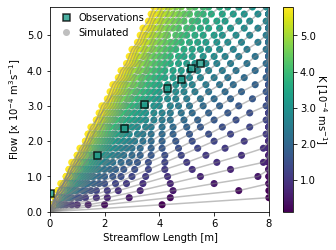

In [140]:
size_human_units = [115,85]
fig = plt.figure(figsize=mm_to_inches(size_human_units))
ax = fig.add_subplot(111)
toe_locations = results['multi_uniform_var_k'][0]
water_balances = results['multi_uniform_var_k'][1]
toe_locations_max = max([toe_locations[key]['toe_loc'].max() for key in toe_locations])
flow_max = max([water_balances[key]['Fnodal_1'].max() for key in water_balances])

k_values_map = {}
k_values = []
for folder in results['multi_uniform_var_k'][2]:
    k_values_map[folder] = float(folder.split('_')[-1])
    k_values += [float(folder.split('_')[-1])] 
min_var_val = min(k_values)
max_var_val = max(k_values)

norm = plt.Normalize(min_var_val, max_var_val) #vmin=min_var_val, vmax=max_var_val

for folder in results['multi_uniform_var_k'][2]:
    ax.plot(toe_locations[folder].loc[locs, 'toe_loc'].tolist(), 
            water_balances[folder].loc[locs, "Fnodal_1"].tolist(), c='grey', alpha=0.5)

for folder in results['multi_uniform_var_k'][2]:
    tmp = ax.scatter(x=toe_locations[folder].loc[locs, 'toe_loc'].tolist(), 
            y=water_balances[folder].loc[locs, "Fnodal_1"].tolist(), c=[k_values_map[folder]]*len(k_values), 
                     label=folder,
            cmap='viridis', norm=norm, s=50, edgecolor='none', alpha=1.0, )#,
            #marker='o', markeredgecolor='none', markerfacecolor='blue', linewidth=0)
#ax.legend([x.replace('_',' ') for x in folders], loc='upper left', numpoints=1, 
#          frameon=False, fontsize=10)

ax.set_ylabel('Inflow rate [10$^{-4}$ m$^3$/s]', fontsize=10)
ax.set_xlabel('Length of stream [m]', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlim(0, toe_locations_max)
ax.set_ylim(0, flow_max)

cbar = plt.colorbar(tmp)
cbar.ax.tick_params(labelsize=10)
cbar_labels = cbar.ax.get_yticklabels()
plt.draw()
print([f"{float(yi.get_text()) * 10000:.1f}" for yi in cbar_labels if yi.get_text() != ''])
cbar.ax.set_yticklabels([f"{float(yi.get_text()) * 10000:.1f}" for yi in cbar_labels if yi.get_text() != ''])
cbar.set_label('K [10$^{-4}$ ms$^{-1}$]', rotation=270, fontsize=10, labelpad=13)
#cbar.set_label('K [10$^{-4}$ m/s]', rotation=270, fontsize=10, labelpad=13)

cbar_clim = cbar.mappable.get_clim()

K_experimental = 3.2E-4
K_experimental_normalised_for_cbar = (K_experimental - cbar_clim[0]) / (cbar_clim[1] - cbar_clim[0])
cbar.ax.plot([0, 1], [K_experimental_normalised_for_cbar] * 2, color='black', linewidth=1.5)

cmap = mpl.cm.get_cmap('viridis')

stream_toe_observed.plot(x=' Streamflow Length [m]', y='Flow [m$^3$/s]', linestyle='none',
                         marker='s', ax=ax, markeredgewidth=1.5, 
                         markersize=7, legend=False, alpha=0.8,
                         markerfacecolor=cmap(K_experimental_normalised_for_cbar), markeredgecolor='black')

ax.set_ylabel('Flow [x 10$^{-4}$ m$^3$s$^{-1}$]')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], linestyle='none', marker='s', 
                       markerfacecolor=cmap(K_experimental_normalised_for_cbar),
                       markeredgecolor='black', 
                       markeredgewidth=1.5, markersize=7, alpha=0.8),
               Line2D([0], [0], linestyle='none', marker='o', markerfacecolor='grey', markeredgecolor='none', 
                       markeredgewidth=1.0, markersize=7, alpha=0.5)]

ax.legend(custom_lines, ['Observations', 'Simulated'], numpoints=1, fontsize=10, loc='upper left', frameon=False,
         borderpad=0.1, handletextpad=0.3)

plt.savefig('uniform_K_sampling_updated.png', dpi=300)   

new_yticklabels = [f"{float(yi.get_text())*10000:.1f}" for yi in ax.get_yticklabels() if yi.get_text() != '']
ax.set_yticklabels(new_yticklabels)

plt.subplots_adjust(top=0.98, bottom=0.13, left=0.14, right=0.98)
plt.savefig('uniform_K_sampling_updated.png', dpi=300)   

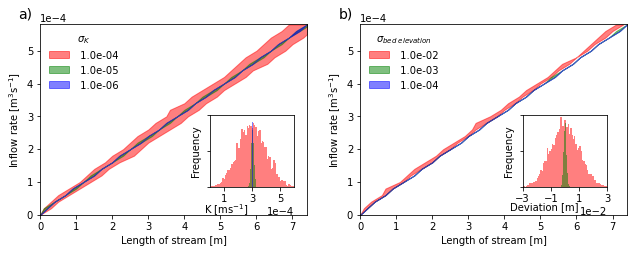

In [114]:
size_human_units2 = [115 * 2,85]
fig = plt.figure(figsize=mm_to_inches(size_human_units2))
ax = fig.add_subplot(121)
three_col = ['r', 'g', 'b']
k_sigma_results = {}
for num, k_sigma in enumerate(hetero_vars['k']['sigmas']):
    k_sigma_results[k_sigma] = results['multi_heterogeneous_k_{}'.format(k_sigma)]
    toe_loc_tmp = results['multi_heterogeneous_k_{}'.format(k_sigma)][0]
    water_bal_tmp = results['multi_heterogeneous_k_{}'.format(k_sigma)][1]
    toe_loc_max = 0
    flow_max = 0
    for ind, mkey in enumerate(toe_loc_tmp):
        toe_loc_max_tmp = max([toe_loc_tmp[key]['toe_loc'].max() for key in toe_loc_tmp])
        flow_max_tmp = max([water_bal_tmp[key]['Fnodal_1'].max() for key in water_bal_tmp])
        if toe_loc_max_tmp > toe_loc_max:
            toe_loc_max = toe_loc_max_tmp
        if flow_max_tmp > flow_max:
            flow_max = flow_max_tmp
        tl = toe_loc_tmp[mkey].loc[locs, 'toe_loc'].tolist() 
        wb_ = water_bal_tmp[mkey].loc[locs, "Fnodal_1"].tolist()
        if ind == 0:
            combined_toes = pd.DataFrame(data={mkey.split('_')[-1]:tl}, index=wb_)
        else:
            combined_toes.loc[:, mkey.split('_')[-1]] = tl
    upper = combined_toes.max(axis=1).tolist()
    lower = combined_toes.min(axis=1).tolist()
    ax.fill_betweenx(wb_, lower, upper, alpha=0.5, label='{0: 1.1e}'.format(float(k_sigma)), color=three_col[num])
ax.legend(fontsize=10, loc='upper left', frameon=False, title= '$\sigma _{K}$')    
ax.set_ylabel('Inflow rate [m$^3$s$^{-1}$]', fontsize=10)
ax.set_xlabel('Length of stream [m]', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlim(0, toe_loc_max)
ax.set_ylim(0, flow_max)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.text(-0.6, 0.0006, "a)", fontsize=14)

left, bottom, width, height = [0.34, 0.245, 0.13, 0.30]
ax2 = fig.add_axes([left, bottom, width, height])
for num, k_sigma in enumerate(hetero_vars['k']['sigmas']):
    ax2.hist(np.random.normal(hetero_vars['k']['mu'], k_sigma, samples * 161), bins=80, color=three_col[num], 
             alpha=0.5, linewidth=0)

ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_xlabel('K [ms$^{-1}$]', x=0.2, fontsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='minor', labelsize=8)
ax2.set_xticks(np.arange(0.0001, 0.0006, step=0.0002))
#ax2_lim = ax2.get_xlim()
ax2.set_xlim(0, 0.0006)#ax2_lim[1])
ax2.set_ylim(0, 200)
ax2.xaxis.labelpad = -2
ax2.yaxis.labelpad = 2
ax2.set_yticklabels('')    
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# __________________________________________________________

ax3 = fig.add_subplot(122)
three_col = ['r', 'g', 'b']
be_sigma_results = {}
for num, be_sigma in enumerate(hetero_vars['bed_elevation']['sigmas']):
    be_sigma_results[be_sigma] = results['multi_bed_elevation_{}'.format(be_sigma)]
    toe_loc_tmp = results['multi_bed_elevation_{}'.format(be_sigma)][0]
    water_bal_tmp = results['multi_bed_elevation_{}'.format(be_sigma)][1]
    toe_loc_max = 0
    flow_max = 0
    for ind, mkey in enumerate(toe_loc_tmp):
        toe_loc_max_tmp = max([toe_loc_tmp[key]['toe_loc'].max() for key in toe_loc_tmp])
        flow_max_tmp = max([water_bal_tmp[key]['Fnodal_1'].max() for key in water_bal_tmp])
        if toe_loc_max_tmp > toe_loc_max:
            toe_loc_max = toe_loc_max_tmp
        if flow_max_tmp > flow_max:
            flow_max = flow_max_tmp
        tl = toe_loc_tmp[mkey].loc[locs, 'toe_loc'].tolist() 
        wb_ = water_bal_tmp[mkey].loc[locs, "Fnodal_1"].tolist()
        if ind == 0:
            combined_toes = pd.DataFrame(data={mkey.split('_')[-1]:tl}, index=wb_)
        else:
            combined_toes.loc[:, mkey.split('_')[-1]] = tl
    upper = combined_toes.max(axis=1).tolist()
    lower = combined_toes.min(axis=1).tolist()
    ax3.fill_betweenx(wb_, lower, upper, alpha=0.5, label='{0: 1.1e}'.format(float(be_sigma)), color=three_col[num])
ax3.legend(fontsize=10, loc='upper left', frameon=False, title= '$\sigma _{bed\ elevation}$')    
ax3.set_ylabel('Inflow rate [m$^3$s$^{-1}$]', fontsize=10)
ax3.set_xlabel('Length of stream [m]', fontsize=10)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.tick_params(axis='both', which='minor', labelsize=8)
ax3.set_xlim(0, toe_loc_max)
ax3.set_ylim(0, flow_max)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax3.text(-0.6, 0.0006, "b)", fontsize=14)


left, bottom, width, height = [0.82, 0.245, 0.13, 0.30]
ax4 = fig.add_axes([left, bottom, width, height])
for num, be_sigma in enumerate(hetero_vars['bed_elevation']['sigmas']):
    ax4.hist(np.random.normal(hetero_vars['bed_elevation']['mu'], be_sigma, samples * 161), bins=80, 
             color=three_col[num], alpha=0.5, linewidth=0)

ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_xlabel('Deviation [m]', x=0.25, fontsize=10)
ax4.tick_params(axis='both', which='major', labelsize=10)
ax4.tick_params(axis='both', which='minor', labelsize=8)
ax4.set_xticks(np.arange(-0.03, 0.04, step=0.02))
#ax2_lim = ax2.get_xlim()
ax4.set_xlim(-0.03, 0.03)#ax2_lim[1])
ax4.set_ylim(0, 200)
ax4.xaxis.labelpad = -2
ax4.yaxis.labelpad = 2
ax4.set_yticklabels('')    
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.subplots_adjust(top=0.92, bottom=0.13, left=0.08, right=0.98)

#plt.savefig('hetero_K_hetero_bed_elev_sampling.png', dpi=300)  